### Importing data and spilting them

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
data = load_breast_cancer()
X, y = data.data, data.target


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,       
    random_state=42,
    stratify=y
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,       
    random_state=42,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 398
Validation size: 85
Test size: 86


### Libaray implementation 

Validation Accuracy: 0.9647058823529412

Confusion Matrix:
 [[32  0]
 [ 3 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.94      0.97        53

    accuracy                           0.96        85
   macro avg       0.96      0.97      0.96        85
weighted avg       0.97      0.96      0.96        85



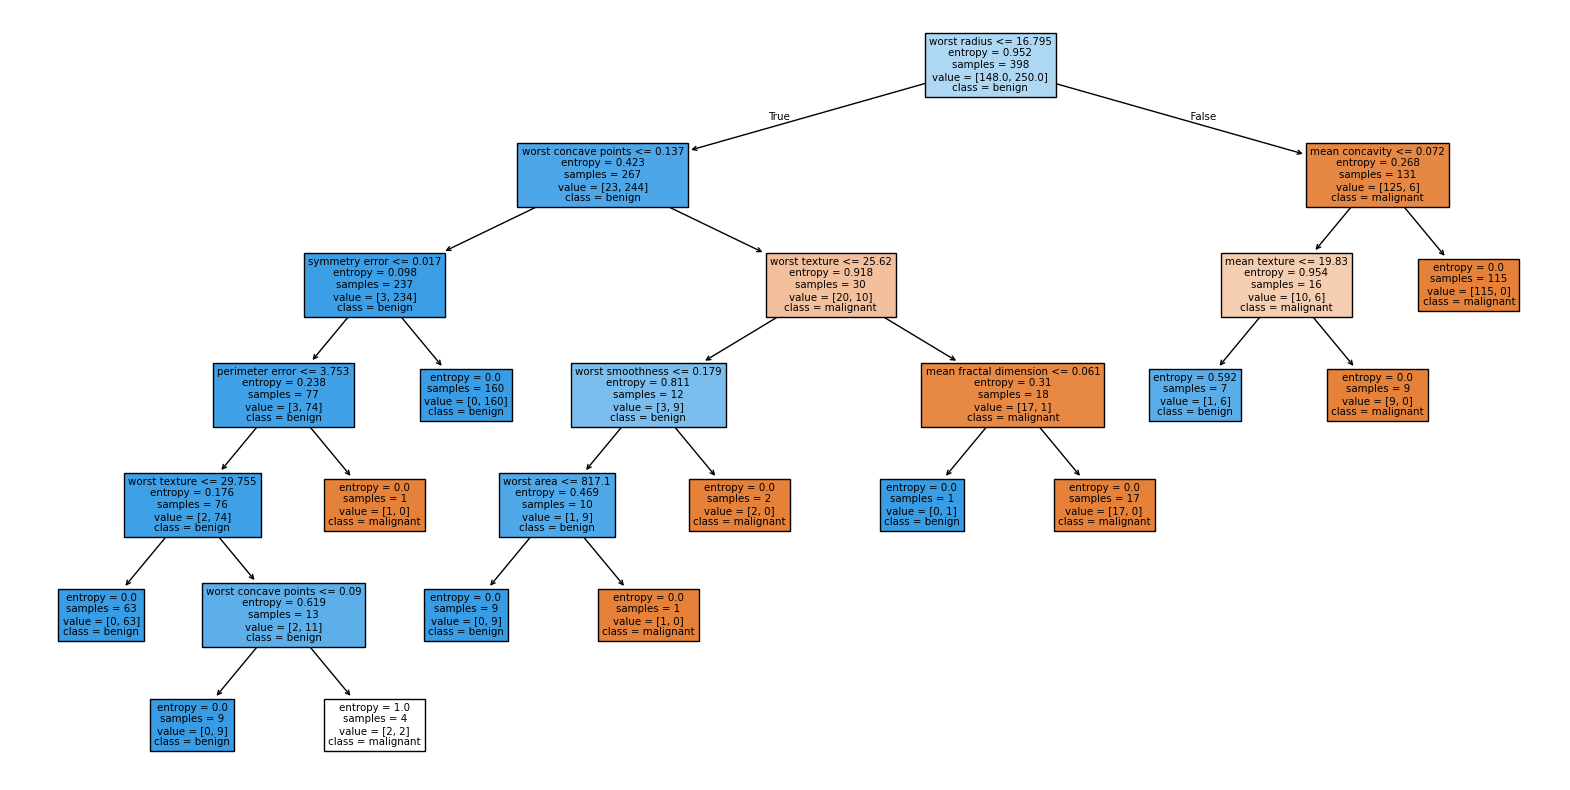

In [2]:
tree = DecisionTreeClassifier(
    max_depth=10,       # max depth to prevent overfitting
    criterion='entropy',  # or 'entropy'
    random_state=42,
    min_samples_split=10
    
)  
tree.fit(X_train, y_train)
y_val_pred = tree.predict(X_val)


print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# 8️⃣ Optional: visualize the tree
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=data.feature_names, class_names=data.target_names, filled=True)
plt.show()

### Manual implementation

In [3]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [16]:
class tree:
    feat_importance = []
    def __init__(self, max_depth=None, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.n_features = n_features
    
    def fit(self, X, y):
        self.root = self.build_tree(X, y, 0)
    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for x in X])
    
    def build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)

        feature_index, threshold = self.best_split(X, y)
        if feature_index is None:
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self.split(X[:, feature_index], threshold)
        left = self.build_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self.build_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return  Node(feature=feature_index, threshold=threshold, left=left, right=right)
    
    def most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
    
    def best_split(self, X, y):
        best_gain = -1
        best_idx = None
        best_thresh = None
        n_features = X.shape[1]
        features = np.arange(n_features)
        if self.n_features is not None:
            features = np.random.choice(features, self.n_features, replace=False)
        for feature_index in features:
            spilts = self.spiltsForFeature(X, feature_index)
            X_column = X[:, feature_index]
            for threshold in spilts:
                ig = self.information_gain(y, X_column, threshold)
                if ig > best_gain:
                    best_gain = ig
                    best_idx = feature_index
                    best_thresh = threshold
        self.feat_importance.append(best_idx)
        return best_idx, best_thresh
    def getrankedfeatures(self, feature_names=None):
        seen = []
        ranked = []
        for f in self.feat_importance:
            if f not in seen:
                seen.append(f)
                ranked.append(f)

        if feature_names is not None:
            ranked = [feature_names[i] for i in ranked]

        return ranked

    def spiltsForFeature(self, X, feature_index):
        feature_values = X[:, feature_index] 
        sorted_values = np.sort(np.unique(feature_values)) 
        values = []
        for i in range(1, len(sorted_values)):
            values.append((sorted_values[i] + sorted_values[i-1]) / 2)
        return values

    def information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self.split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        information_gain = parent_entropy - child_entropy
        return information_gain

    def split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])


    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)



In [19]:
clf = tree(max_depth=10, min_samples_split=10)
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

ranked = clf.getrankedfeatures(feature_names=data.feature_names)

ranked = [str(f) for f in ranked]

print("Ranked Features by importance:", ranked)



Validation Accuracy: 0.9647058823529412

Confusion Matrix:
 [[32  0]
 [ 3 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.94      0.97        53

    accuracy                           0.96        85
   macro avg       0.96      0.97      0.96        85
weighted avg       0.97      0.96      0.96        85

Ranked Features by importance: ['worst radius', 'worst concave points', 'symmetry error', 'radius error', 'worst texture', 'mean smoothness', 'worst area', 'mean fractal dimension', 'mean concavity', 'mean texture']


### Hyperparamater analysis 

In [12]:
depths = [2, 4, 6, 8, 10]
min_samples_splits = [2, 5, 10]
results = {}
train_acc = []
val_acc = []

for depth in depths:
    depth_train_acc = []
    depth_val_acc = []
    for min_samples in min_samples_splits:
        clf = tree(max_depth=depth, min_samples_split=min_samples)
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_val_pred = clf.predict(X_val)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        depth_train_acc.append(train_accuracy)
        depth_val_acc.append(val_accuracy)
        results[(depth, min_samples)] = val_accuracy

        print(f"Depth: {depth}, Min Samples Split: {min_samples}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    best_idx = depth_val_acc.index(max(depth_val_acc))
    train_acc.append(depth_train_acc[best_idx])
    val_acc.append(max(depth_val_acc))

best_params = max(results, key=results.get)
print(f"Best Parameters: Depth: {best_params[0]}, Min Samples Split: {best_params[1]}, Validation Accuracy: {results[best_params]:.4f}")

clf = tree(max_depth=best_params[0], min_samples_split=best_params[1])
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])
clf.fit(X_train_full, y_train_full)
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Best Parameters: {test_accuracy:.4f}")


Depth: 2, Min Samples Split: 2, Train Accuracy: 0.9523, Validation Accuracy: 0.9176
Depth: 2, Min Samples Split: 5, Train Accuracy: 0.9523, Validation Accuracy: 0.9176
Depth: 2, Min Samples Split: 10, Train Accuracy: 0.9523, Validation Accuracy: 0.9176
Depth: 4, Min Samples Split: 2, Train Accuracy: 0.9925, Validation Accuracy: 0.9882
Depth: 4, Min Samples Split: 5, Train Accuracy: 0.9925, Validation Accuracy: 0.9882
Depth: 4, Min Samples Split: 10, Train Accuracy: 0.9899, Validation Accuracy: 0.9882
Depth: 6, Min Samples Split: 2, Train Accuracy: 0.9950, Validation Accuracy: 0.9647
Depth: 6, Min Samples Split: 5, Train Accuracy: 0.9950, Validation Accuracy: 0.9647
Depth: 6, Min Samples Split: 10, Train Accuracy: 0.9925, Validation Accuracy: 0.9647
Depth: 8, Min Samples Split: 2, Train Accuracy: 1.0000, Validation Accuracy: 0.9882
Depth: 8, Min Samples Split: 5, Train Accuracy: 0.9950, Validation Accuracy: 0.9647
Depth: 8, Min Samples Split: 10, Train Accuracy: 0.9925, Validation Accur

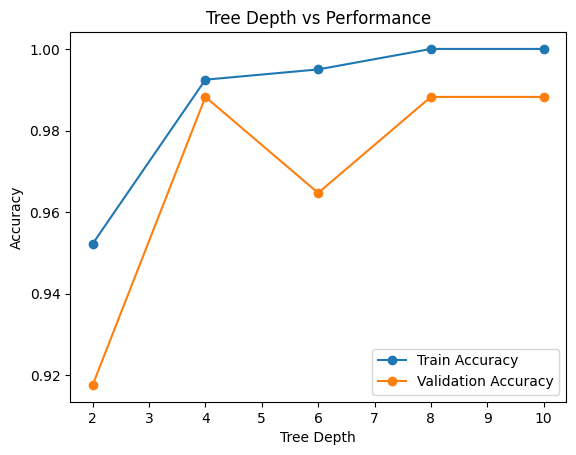

In [13]:
plt.plot(depths, train_acc, marker='o', label='Train Accuracy')
plt.plot(depths, val_acc, marker='o', label='Validation Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Tree Depth vs Performance')
plt.legend()
plt.show()

### Overfitting Analysis

We analyzed the model’s performance with different tree depths and minimum samples split values. Shallow trees (depth = 2) had lower training and validation accuracies, showing slight underfitting. Trees with depth 4 achieved high training (≈0.9925) and validation (0.9882) accuracies with a small gap, indicating good generalization. Deeper trees (depth ≥6) had near-perfect training accuracy but lower validation accuracy, showing overfitting. The best parameters were depth 4 and min samples split 2. The test accuracy with these parameters was 0.8837, suggesting a small generalization gap.


In [7]:
depths = [2, 4, 6, 8, 10]
min_samples_split = 5

results = {}   

for depth in depths:
    clf = tree(max_depth=depth, min_samples_split=min_samples_split)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    y_val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    results[depth] = (train_acc, val_acc)
    print(f"Depth: {depth}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    
print("\nSummary Table:")
print("Depth | Train Accuracy | Validation Accuracy")
print("---------------------------------------------")
for depth in depths:
    train_acc, val_acc = results[depth]
    print(f"{depth:<5} | {train_acc:.4f}         | {val_acc:.4f}")


Depth: 2, Train Accuracy: 0.9523, Validation Accuracy: 0.9176
Depth: 4, Train Accuracy: 0.9925, Validation Accuracy: 0.9882
Depth: 6, Train Accuracy: 0.9950, Validation Accuracy: 0.9647
Depth: 8, Train Accuracy: 0.9950, Validation Accuracy: 0.9647
Depth: 10, Train Accuracy: 0.9950, Validation Accuracy: 0.9647

Summary Table:
Depth | Train Accuracy | Validation Accuracy
---------------------------------------------
2     | 0.9523         | 0.9176
4     | 0.9925         | 0.9882
6     | 0.9950         | 0.9647
8     | 0.9950         | 0.9647
10    | 0.9950         | 0.9647


### Dataforest

In [8]:
class random_forest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_trees):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[idxs]
            y_sample = y[idxs]
            temptree = tree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, n_features=self.n_features)
            temptree.fit(X_sample, y_sample)
            self.trees.append(temptree)
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(y_pred)

In [9]:
from math import sqrt, floor
from collections import Counter

d = X_train.shape[1]
max_features_options = [floor(sqrt(d)), floor(d/2)]
T_options = [5, 10, 30, 50]

best_acc = 0
best_params = {}
for T in T_options:
    for max_features in max_features_options:
        rf = random_forest(
            n_trees=T, 
            max_depth=4,         
            min_samples_split=2, 
            n_features=max_features
        )
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        print(f"T={T}, max_features={max_features}, Validation Accuracy={acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            best_params = {'n_trees': T, 'max_features': max_features}

X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

rf_final = random_forest(
    n_trees=best_params['n_trees'],
    max_depth=4,
    min_samples_split=2,
    n_features=best_params['max_features']
)

rf_final.fit(X_train_val, y_train_val)
y_test_pred = rf_final.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


T=5, max_features=5, Validation Accuracy=0.9765
T=5, max_features=15, Validation Accuracy=0.9882
T=10, max_features=5, Validation Accuracy=0.9882
T=10, max_features=15, Validation Accuracy=0.9765
T=30, max_features=5, Validation Accuracy=0.9765
T=30, max_features=15, Validation Accuracy=1.0000
T=50, max_features=5, Validation Accuracy=0.9882
T=50, max_features=15, Validation Accuracy=0.9882
Test Accuracy: 0.8953488372093024
Confusion Matrix:
 [[26  6]
 [ 3 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.89      0.94      0.92        54

    accuracy                           0.90        86
   macro avg       0.90      0.88      0.89        86
weighted avg       0.90      0.90      0.89        86



### Comparison of Single Decision Tree and Random Forest

The single decision tree achieved a validation accuracy of 0.9647 and a test accuracy of 0.8837. Its confusion matrix shows some misclassifications, particularly for class 0, and the model relies heavily on the top-ranked features such as 'worst radius' and 'worst concave points'. Increasing tree depth improved training accuracy but sometimes reduced validation performance, indicating overfitting at higher depths. In contrast, the random forest achieved a higher test accuracy of 0.8953, with improved generalization and fewer misclassifications. This improvement occurs because the random forest aggregates multiple trees, reducing variance while maintaining low bias. Overall, the single decision tree exhibits lower variance but higher sensitivity to its depth and splitting decisions, whereas the random forest balances bias and variance more effectively, resulting in more stable predictions.
